## MySQL Employees Sample Database
Using the MySQL Employees sample database to practice and learn SQL/MySQL before using Python and R to analyze queried data. Information about the database can be found at [https://dev.mysql.com/doc/employee/en/](https://dev.mysql.com/doc/employee/en/). The database can be downloaded at [https://github.com/datacharmer/test_db](https://github.com/datacharmer/test_db).

### Tools used
- Package pandas for dataframes and functions such as read_sql_query
- Package numpy for general math functions
- Package MySQLdb to connect to MySQL
- Package scipy.stats for statistical testing
- Packages matplotlib and seaborn for plotting

Creating a connection to MySQL, replace "yourusername" and "yourpassword" with the username/password to your MySQL.

In [11]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Server connection to MySQL:
import MySQLdb
conn = MySQLdb.connect(host= "localhost",
                  user="yourusername",
                  passwd="yourpassword",
                  db="employees")

x = conn.cursor()

### Employee promotions
In this section, I answer some questions regarding promotions within this fictional company.
1. How many promotions were given? To how many employees?
2. Has any employee been promoted more than once? What is the maximum times an employee has been promoted?
3. How many employees were never promoted or left before being promoted?
4. What is the average time before an employee is promoted? Is there noticeable discrimination based on gender or age?

In MySQL I created a view named Promotions that I will reference but views cannot be created in Python:
```
CREATE OR REPLACE VIEW Promotions AS
SELECT employees.emp_no, birth_date, first_name, last_name, gender, a.from_date AS hire_date, a.title AS hire_title, a.to_date AS promotion_date, b.title AS promoted_to, b.to_date AS end_date
FROM employees JOIN titles a ON employees.emp_no = a.emp_no JOIN titles b ON a.emp_no = b.emp_no
WHERE a.to_date = b.from_date AND a.title != b.title;
```

##### 1. How many promotions were given? To how many employees?

In [10]:
### Finding all promotions
promotions = pd.read_sql_query("""
SELECT employees.emp_no, birth_date, first_name, last_name, gender, a.from_date AS hire_date, a.title AS hire_title, a.to_date AS promotion_date, b.title AS promoted_to, b.to_date AS end_date
FROM employees JOIN titles a ON employees.emp_no = a.emp_no JOIN titles b ON a.emp_no = b.emp_no
WHERE a.to_date = b.from_date AND a.title != b.title;
""", conn)
promotions.head()

,emp_no,birth_date,first_name,last_name,gender,hire_date,hire_title,promotion_date,promoted_to,end_date
0,10004,1954-05-01,Chirstian,Koblick,M,1986-12-01,Engineer,1995-12-01,Senior Engineer,9999-01-01
1,10005,1955-01-21,Kyoichi,Maliniak,M,1989-09-12,Staff,1996-09-12,Senior Staff,9999-01-01
2,10007,1957-05-23,Tzvetan,Zielinski,F,1989-02-10,Staff,1996-02-11,Senior Staff,9999-01-01
3,10009,1952-04-19,Sumant,Peac,F,1985-02-18,Assistant Engineer,1990-02-18,Engineer,1995-02-18
4,10009,1952-04-19,Sumant,Peac,F,1990-02-18,Engineer,1995-02-18,Senior Engineer,9999-01-01


Notice how some employees have been promoted more than once (emp_no = 10009)

In [11]:
### Number of promotions
pd.read_sql_query("""
SELECT COUNT(*)
FROM Promotions;
""", conn)

,COUNT(*)
0,143284


In [12]:
### Number of employees who received promotions
pd.read_sql_query("""
SELECT COUNT(DISTINCT(emp_no))
FROM Promotions;
""", conn)

,COUNT(DISTINCT(emp_no))
0,140270


We find that 143,294 promotions were given by this company to 140,270 employees. There are more promotions given than employees which leads into the next question.

##### 2. Has any employee been promoted more than once? What is the maximum times an employee has been promoted?

In [13]:
### Finding employees who have been promoted more than once
df = pd.read_sql_query("""
SELECT emp_no, COUNT(emp_no) AS times_promoted
FROM Promotions
GROUP BY emp_no
HAVING COUNT(*) > 1
""", conn)
df.head()

,emp_no,times_promoted
0,10009,2
1,10066,2
2,10258,2
3,10451,2
4,10571,2


In [16]:
### Finding how many employees were promoted more than once
pd.read_sql_query("""
SELECT COUNT(*)
FROM
(SELECT emp_no, COUNT(emp_no) AS times_promoted
FROM Promotions
GROUP BY emp_no
HAVING COUNT(*) > 1) AS a;
""", conn)

,COUNT(*)
0,3014


In [14]:
### Finding the maximum number of promotions by a single employee
pd.read_sql_query("""
SELECT MAX(times_promoted)
FROM 
(SELECT emp_no, COUNT(emp_no) AS times_promoted
FROM Promotions
GROUP BY emp_no
HAVING COUNT(*) > 1) AS a;
""", conn)

,MAX(times_promoted)
0,2


We find that 3,014 employees have been promoted twice, and that no employees have ever been promoted three times.

##### 3. How many employees were never promoted or left before being promoted?

In [17]:
### Finding all employees who have never been promoted or left before a promotion
df = pd.read_sql_query("""
SELECT employees.emp_no, birth_date, first_name, last_name, gender, hire_date, title, from_date, to_date
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no
HAVING COUNT(employees.emp_no) = 1;
""", conn)
df.head()

,emp_no,birth_date,first_name,last_name,gender,hire_date,title,from_date,to_date
0,10001,1953-09-02,Georgi,Facello,M,1986-06-26,Senior Engineer,1986-06-26,9999-01-01
1,10002,1964-06-02,Bezalel,Simmel,F,1985-11-21,Staff,1996-08-03,9999-01-01
2,10003,1959-12-03,Parto,Bamford,M,1986-08-28,Senior Engineer,1995-12-03,9999-01-01
3,10006,1953-04-20,Anneke,Preusig,F,1989-06-02,Senior Engineer,1990-08-05,9999-01-01
4,10008,1958-02-19,Saniya,Kalloufi,M,1994-09-15,Assistant Engineer,1998-03-11,2000-07-31


In [19]:
### Finding how many employees that have never been promoted or left before a promotion
pd.read_sql_query("""
SELECT COUNT(*)
FROM
(SELECT employees.emp_no, birth_date, first_name, last_name, gender, hire_date, title, from_date, to_date
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no
HAVING COUNT(employees.emp_no) = 1) AS a;
""", conn)

,COUNT(*)
0,159754


We find that 159,754 employees have never been promoted or left before a promotion.

##### 4. What is the average time before an employee is promoted? Is there noticeable discrimination based on gender or age?

In [25]:
### Finding the time before an employee is promoted
df = pd.read_sql_query("""
SELECT emp_no, gender, TIMESTAMPDIFF(DAY, hire_date, promotion_date) AS days_to_promotion
FROM promotions;
""", conn)
df.head()

,emp_no,gender,days_to_promotion
0,10004,M,3287
1,10005,M,2557
2,10007,F,2557
3,10009,F,1826
4,10009,F,1826


In [23]:
### Grouping on gender and taking the average
pd.read_sql_query("""
SELECT gender, AVG(days_to_promotion)
FROM
(SELECT emp_no, gender, TIMESTAMPDIFF(DAY, hire_date, promotion_date) AS days_to_promotion
FROM promotions) AS a
GROUP BY gender;
""", conn)

,gender,AVG(days_to_promotion)
0,M,2473.6378
1,F,2469.7197


Let us visualize the distributions of days until promotion for males and females.

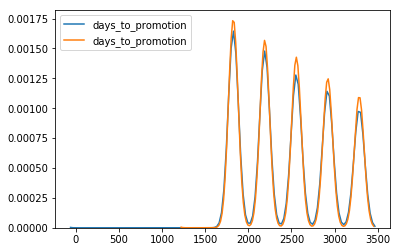

In [58]:
# Group by gender
df1 = df.groupby(['gender'])

# Plot density plots
sns.kdeplot(df1.get_group('F')['days_to_promotion'])
sns.kdeplot(df1.get_group('M')['days_to_promotion'])

We see they have roughly the same distribution and similar peaks, leading me to conclude that there is no discrimination between genders. Something to note is that some employees have the same number of days before a promotion (e.g. emp_no = 10005 and 10007) and the number of days is very close to a multiple of days in a year (365 days approximately). This leads me to believe that employees are promoted on or near their hire dates, most likely at their yearly reviews.

In [4]:
### Finding the age of employees when they were promoted
df = pd.read_sql_query("""
SELECT emp_no, gender, birth_date, promotion_date, TIMESTAMPDIFF(YEAR, birth_date, promotion_date) AS age_at_promotion
FROM promotions;
""", conn)
df.head()

,emp_no,gender,birth_date,promotion_date,age_at_promotion
0,10004,M,1954-05-01,1995-12-01,41
1,10005,M,1955-01-21,1996-09-12,41
2,10007,F,1957-05-23,1996-02-11,38
3,10009,F,1952-04-19,1990-02-18,37
4,10009,F,1952-04-19,1995-02-18,42


In [6]:
### Grouping on gender and taking the average
pd.read_sql_query("""
SELECT gender, AVG(age_at_promotion)
FROM 
(SELECT emp_no, gender, birth_date, promotion_date, TIMESTAMPDIFF(YEAR, birth_date, promotion_date) AS age_at_promotion
FROM promotions) AS a
GROUP BY gender;
""", conn)

,gender,AVG(age_at_promotion)
0,M,38.1015
1,F,38.0952


Let us visualize the distributions of ages of promoted employees for males and females.

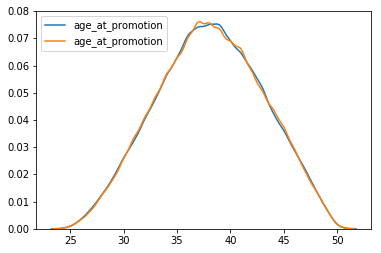

In [8]:
# Group by gender
df2 = df.groupby(['gender'])

# Plot density plots
sns.kdeplot(df2.get_group('F')['age_at_promotion'])
sns.kdeplot(df2.get_group('M')['age_at_promotion'])

We see a much nicer and parametric distribution compared to the distribution of days until promotions. This bell curve distribution shape implies a Gaussian/normal distribution which we can test for. Assumption for a normality test such as the Shapiro-Wilk test are that observations are independent and identically distributed (iid) which is a fair assumption given observations are different employees for the most part. Some employees show up multiple times because they were promoted more than once (e.g. emp_no = 10009). We can obtain the first promotion for employees with multiple promotions by grouping on their employee id.

In [14]:
# Group on emp_no to obtain the age at first promotion for all employees
df = pd.read_sql_query("""
SELECT emp_no, gender, birth_date, promotion_date, TIMESTAMPDIFF(YEAR, birth_date, promotion_date) AS age_at_promotion
FROM promotions
GROUP BY emp_no;
""", conn)
df.head()

,emp_no,gender,birth_date,promotion_date,age_at_promotion
0,10004,M,1954-05-01,1995-12-01,41
1,10005,M,1955-01-21,1996-09-12,41
2,10007,F,1957-05-23,1996-02-11,38
3,10009,F,1952-04-19,1990-02-18,37
4,10012,M,1960-10-04,2000-12-18,40


In [27]:
# Testing for normality
stat, pF = stats.normaltest(df.groupby('gender').get_group('F')['age_at_promotion'])
stat, pM = stats.normaltest(df.groupby('gender').get_group('M')['age_at_promotion'])
{'gender': ['M', 'F'], 'p-values': [pM, pF]}

{'gender': ['M', 'F'], 'p-values': [0.0, 0.0]}

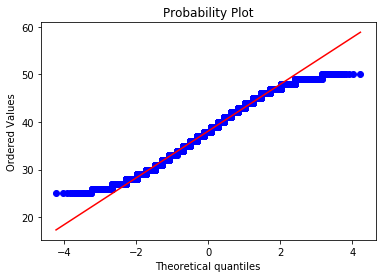

In [21]:
# Quantile-quantile (qq) plot of the residuals
res = stats.probplot(df2.get_group('F')['age_at_promotion'], plot = plt)

We see that our p-values for both genders is 0 so we reject our null hypothesis that the distribution is normal and conclude that our distribution is not Gaussian/normal. We can see from the above qq-plot that the tails of our distribution are non-existent. This means the company is not promoting (or hiring) anyone who is under a minimum age or above a maximum age (i.e. they do not promote (or hire) teenagers or people close to retirement age).

### Past employees
Let's take a look at the past employees at this company.
1. How many past employees does this company have?
2. Find the ages of new hires. What is the average hire age? Plot the distribution.
3. Find the ages of employees when they left the company. What is the average age of employees leaving the company? Plot the distribution.
4. Combine the previous two questions to find the time spent at the company by past employees. Any interesting observations?

##### 1. How many past employees does this company have?

In [6]:
### Finding employees who have left the company. Current employees have to_date set to '9999-01-01'
df = pd.read_sql_query("""
SELECT employees.*, to_date
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no
HAVING MAX(to_date) < DATE '9999-01-01';
""", conn)
df.head()

,emp_no,birth_date,first_name,last_name,gender,hire_date,to_date
0,10008,1958-02-19,Saniya,Kalloufi,M,1994-09-15,2000-07-31
1,10011,1953-11-07,Mary,Sluis,F,1990-01-22,1996-11-09
2,10015,1959-08-19,Guoxiang,Nooteboom,M,1987-07-02,1993-08-22
3,10021,1960-02-20,Ramzi,Erde,M,1988-02-10,2002-07-15
4,10025,1958-10-31,Prasadram,Heyers,M,1987-08-17,1997-10-15


In [8]:
### Finding how many past employees there are
pd.read_sql_query("""
SELECT COUNT(DISTINCT(emp_no))
FROM
(SELECT employees.*, to_date
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no
HAVING MAX(to_date) < DATE '9999-01-01') AS a;
""", conn)

,COUNT(DISTINCT(emp_no))
0,59900


We find that 59,900 employees have left this company.

##### 2. Find the ages of new hires. What is the average hire age? Plot the distribution.

In [43]:
### Finding the hire age of all employees
new_hire = pd.read_sql_query("""
SELECT employees.emp_no, birth_date, first_name, last_name, gender, hire_date, TIMESTAMPDIFF(YEAR, birth_date, hire_date) AS hire_age
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no;
""", conn)
df.head()

,emp_no,birth_date,first_name,last_name,gender,hire_date,to_date,leaving_age
0,10008,1958-02-19,Saniya,Kalloufi,M,1994-09-15,2000-07-31,42
1,10011,1953-11-07,Mary,Sluis,F,1990-01-22,1996-11-09,43
2,10015,1959-08-19,Guoxiang,Nooteboom,M,1987-07-02,1993-08-22,34
3,10021,1960-02-20,Ramzi,Erde,M,1988-02-10,2002-07-15,42
4,10025,1958-10-31,Prasadram,Heyers,M,1987-08-17,1997-10-15,38


In [11]:
### Finding the average hire age
pd.read_sql_query("""
SELECT AVG(hire_age)
FROM
(SELECT employees.emp_no, birth_date, first_name, last_name, gender, hire_date, TIMESTAMPDIFF(YEAR, birth_date, hire_date) AS hire_age
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no) AS a;
""", conn)

,AVG(hire_age)
0,30.9972


We find that employees are hired at an average age of approximately 31 years old.

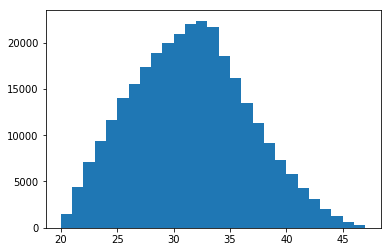

In [46]:
### Plot the distribution of ages for new hires
a = plt.hist(new_hire['hire_age'], bins = (max(new_hire['hire_age']) - min(new_hire['hire_age'])))

In [41]:
new_hire

(array([ 1461.,  4410.,  7059.,  9319., 11666., 14004., 15477., 17389.,
        18849., 19995., 20882., 21984., 22357., 21700., 18577., 16190.,
        13483., 11326.,  9188.,  7339.,  5765.,  4323.,  3067.,  2037.,
         1266.,   631.,   280.]),
 array([20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.,
        33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45.,
        46., 47.]),
 <a list of 27 Patch objects>)

##### 3. Find the ages of employees when they left the company. What is the average age of employees leaving the company? Plot the distribution.

In [48]:
### Finding the age of employees when they left the company
past_employees = pd.read_sql_query("""
SELECT employees.*, to_date, TIMESTAMPDIFF(YEAR, birth_date, to_date) AS leaving_age
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no
HAVING MAX(to_date) < '9999-01-01';
""", conn)
df.head()

,emp_no,birth_date,first_name,last_name,gender,hire_date,to_date,leaving_age
0,10008,1958-02-19,Saniya,Kalloufi,M,1994-09-15,2000-07-31,42
1,10011,1953-11-07,Mary,Sluis,F,1990-01-22,1996-11-09,43
2,10015,1959-08-19,Guoxiang,Nooteboom,M,1987-07-02,1993-08-22,34
3,10021,1960-02-20,Ramzi,Erde,M,1988-02-10,2002-07-15,42
4,10025,1958-10-31,Prasadram,Heyers,M,1987-08-17,1997-10-15,38


In [19]:
### Finding the average age of employees who left the company
pd.read_sql_query("""
SELECT AVG(leaving_age)
FROM
(SELECT employees.*, to_date, TIMESTAMPDIFF(YEAR, birth_date, to_date) AS leaving_age
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no
HAVING MAX(to_date) < '9999-01-01') AS a;
""", conn)

,AVG(leaving_age)
0,37.9825


We find that on average employees leave when they are approximately 38 years old.

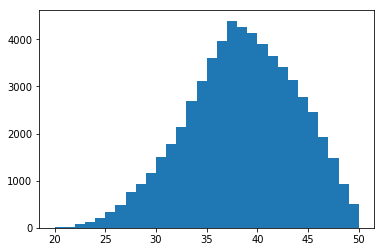

In [49]:
### Plot the distribution of ages for employees who have left
a = plt.hist(past_employees['leaving_age'], bins = (max(past_employees['leaving_age']) - min(past_employees['leaving_age'])))

Let's take a look at the distribution of ages for new and past employees.

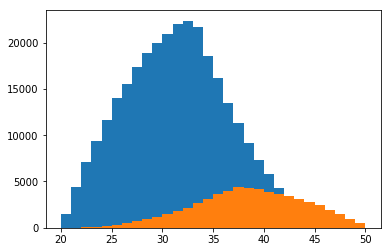

In [64]:
### Both distributions
a = plt.hist(new_hire['hire_age'], bins = (max(new_hire['hire_age']) - min(new_hire['hire_age'])))
a = plt.hist(past_employees['leaving_age'], bins = (max(past_employees['leaving_age']) - min(past_employees['leaving_age'])))

We see that there are a lot more new hires compared to employees leaving the company. This could indicate that the company has grown significantly.

##### 4. Combine the previous two questions to find the time spent at the company by past employees. Any interesting observations?

In [7]:
### Finding past employees of this company and their ages at hire and their last day
df = pd.read_sql_query("""
SELECT a.*, b.to_date, b.leaving_age, CONCAT(TIMESTAMPDIFF(YEAR, a.hire_date, b.to_date), ' years, ', MOD(TIMESTAMPDIFF(MONTH, a.hire_date, b.to_date), 12), ' months') AS time_at_company, TIMESTAMPDIFF(DAY, a.hire_date, b.to_date) AS company_days
FROM
(SELECT employees.emp_no, birth_date, first_name, last_name, gender, hire_date, TIMESTAMPDIFF(YEAR, birth_date, hire_date) AS hire_age
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no) AS a
INNER JOIN
(SELECT employees.*, from_date, to_date, TIMESTAMPDIFF(YEAR, birth_date, to_date) AS leaving_age
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no
HAVING MAX(to_date) < '9999-01-01') AS b ON a.emp_no = b.emp_no;
""", conn)
df.head()

,emp_no,birth_date,first_name,last_name,gender,hire_date,hire_age,to_date,leaving_age,time_at_company,company_days
0,10008,1958-02-19,Saniya,Kalloufi,M,1994-09-15,36,2000-07-31,42,"5 years, 10 months",2146
1,10011,1953-11-07,Mary,Sluis,F,1990-01-22,36,1996-11-09,43,"6 years, 9 months",2483
2,10015,1959-08-19,Guoxiang,Nooteboom,M,1987-07-02,27,1993-08-22,34,"6 years, 1 months",2243
3,10021,1960-02-20,Ramzi,Erde,M,1988-02-10,27,2002-07-15,42,"14 years, 5 months",5269
4,10025,1958-10-31,Prasadram,Heyers,M,1987-08-17,28,1997-10-15,38,"10 years, 1 months",3712


Let's take a look at the distribution of time past employees have worked at the company.

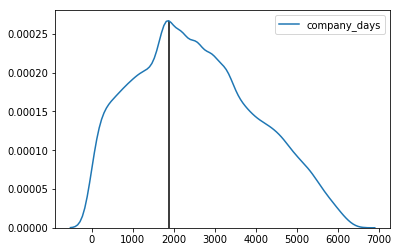

In [17]:
### Plotting the distribution with a line at the peak
p = sns.kdeplot(df['company_days'])
x,y = p.get_lines()[0].get_data()
index = np.argmax(y)
plt.vlines(x[index], 0, y[index])
plt.show()

In [24]:
# Summary statistics on days spent at the company
pd.read_sql_query("""
SELECT MIN(company_days), MAX(company_days), AVG(company_days)
FROM
(SELECT a.*, b.to_date, b.leaving_age, CONCAT(TIMESTAMPDIFF(YEAR, a.hire_date, b.to_date), ' years, ', MOD(TIMESTAMPDIFF(MONTH, a.hire_date, b.to_date), 12), ' months') AS time_at_company, TIMESTAMPDIFF(DAY, a.hire_date, b.to_date) AS company_days
FROM
(SELECT employees.emp_no, birth_date, first_name, last_name, gender, hire_date, TIMESTAMPDIFF(YEAR, birth_date, hire_date) AS hire_age
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no) AS a
INNER JOIN
(SELECT employees.*, from_date, to_date, TIMESTAMPDIFF(YEAR, birth_date, to_date) AS leaving_age
FROM employees JOIN titles ON employees.emp_no = titles.emp_no
GROUP BY employees.emp_no
HAVING MAX(to_date) < '9999-01-01') AS b ON a.emp_no = b.emp_no) AS c;
""", conn)

,MIN(company_days),MAX(company_days),AVG(company_days)
0,0,6388,2555.3828


We see that peak density occurs at approximately 1880 days. On average employees spend approximately 2555 days working at the company with the maximum being 6388 days (about 17 years, 5 months). Some employees have worked less than a full day.